## Reconocimiento de Patrones en Imágenes - Actividad 2  
Cristopher Lincoleo Oyarce  
17-08-2023

La actividad consiste en determinar la mejor combinación de descriptores para diferenciar texturas provenientes de 3 grupos de imágenes contenidas en un archivo .zip.  
Se extraen los siguientes desscriptores:  
1. Contraste
2. Energía
3. Homogeneidad
4. Correlación
5. Disimilaridad
6. Energía (ASM)

Una vez obtenida la matriz de descriptores, se realiza un Análisis Discriminante Lineal para encontrar el par de componentes de desriptores que maximizan la distancia. Esto en base a que LDA es una generalización del discriminante de Fisher.

### 1. Librerias necesarias

In [35]:
#Librerias necesarias

#Tratamiento de imágenes
import cv2
from skimage.feature import graycomatrix, graycoprops
from sklearn import preprocessing
from skimage.io import imread_collection

#Tratamiento de datos
from math import radians
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

#Gráficos
import matplotlib.pyplot as plt

#Modelo LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#direcciones
import glob
import zipfile
import tempfile
import os 
from pathlib import Path #para manejar direcciones

### 2. Carga de datos y generación de dataframe de descriptores

La siguiente función realiza lo siguiente:  

1. Abre un directorio temporal para extraer el contenido del archivo Zip que contiene las imágenes
2. Descomprime el archivo Zip
3. Realiza una búsqueda recursiva de archivos *.jpg*
4. Crea una colección de imágenes 
5. Extrae descriptores de la imagen del canal gris mediante el algoritmo Graycomatrix
6. Genera un dataframe de descriptores y el nombre del archivo
7. Retorna el dataframe

In [36]:
def obtener_features (zip_file_path, level):    
    """ 
    La función recibe:
    zip_file_path: ruta del archivo zip que contiene las imágenes
    level: número de niveles al cual reducir el conjunto de pixeles de la imagen 
    
    Posteriormente procesa las imágenes:
    1. Abre un directorio temporal para extraer el contenido del archivo Zip que contiene las imágenes
    2. Descomprime el archivo Zip
    3. Realiza una búsqueda recursiva de archivos *.jpg*
    4. Crea una colección de imágenes 
    5. Extrae descriptores de la imagen del canal gris mediante el algoritmo Graycomatrix
    6. Genera un dataframe de descriptores y el nombre del archivo
    7. Retorna el dataframe
    """
    features = ['contrast', 'energy', 'homogeneity', 'correlation', 'dissimilarity', 'ASM'] # Características buscadas

    F = [] # Lista para almacenar los descriptores de cada imagen
    
    level = level # Número de niveles al cual reducir el conjunto de pixeles de la imagen
    
    # Ruta al archivo ZIP
    zip_file_path = zip_file_path

    # Crea un directorio temporal para extraer el contenido del ZIP
    with tempfile.TemporaryDirectory() as temp_dir:
        # Descomprime el archivo ZIP en el directorio temporal
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(temp_dir)

        # Patrón para buscar archivos de imágenes
        image_pattern = os.path.join(temp_dir, '**', '*.jpg')

        # Obtén rutas de todas las imágenes encontradas usando glob
        image_paths = glob.glob(image_pattern, recursive=True)

        # Crea una colección de imágenes usando imread_collection
        image_collection = imread_collection(image_paths)

        # Procesamiento y extracción de características para cada imagen
        for image_path, img in zip(image_paths, image_collection):
            # convertimos la imagen a escala de grises
            color_chanel =  cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            #transforma la imagen a una columna
            m_color_chanel = color_chanel.reshape(-1,1)
            
            # Escalamos los datos en una matriz con menos valores
            new_scale = (0,level)
            new_color = MinMaxScaler(new_scale).fit_transform(m_color_chanel).astype(int)

            #volver a transformar el vector en una imagen
            new_color = new_color.reshape(color_chanel.shape)

            # --> algoritmo graycomatrix P01
            # numero de niveles de la imagenq
            l = np.max(new_color)+1

            # extracción de caracteristicas a traves de graycomatrix
            P_1_0 = graycomatrix(new_color, distances=[1], angles=[radians(90)], levels=l, symmetric=False, normed=True)
            texture_features = [graycoprops(P_1_0, ft).ravel()[0] for ft in features]
            #F.append((image_path,) + tuple(texture_features))
            F.append(texture_features)
        
        
        col_names = [f"{feature}" for feature in features]
        # Crear el DataFrame
        texture_df = pd.DataFrame(F, columns=col_names)

        # Convertir las rutas en objetos Path
        image_paths = [Path(path) for path in image_paths]

        # Obtener los nombres de los archivos
        nombres = pd.DataFrame({'nombre_archivo': [path.stem for path in image_paths]})

        # Unir los dataframes
        texture_df = pd.concat([texture_df, nombres], axis=1)

        # Agregar directamente la columna 'ruta_part' utilizando pathlib
        #texture_df['clase_textura'] = [path.parent.name for path in image_paths]   

    # >> FIN ciclo para cada imagen de textura
    return texture_df

In [37]:
# función para asignar clases numéricas a los nombres
def asignar_clase(nombre):
    if 'banded' in nombre:
        return 1
    elif 'striped' in nombre:
        return 2
    elif 'zigzagged' in nombre:
        return 3
    else:
        return 0  # Valor predeterminado o clase desconocida

In [38]:
# Dataframe con los descriptores de cada imagen y su clase
zip_file_path = 'texturas.zip'
level = 15
df = obtener_features(zip_file_path, level)
df['clase'] = df['nombre_archivo'].apply(asignar_clase)
df.drop('nombre_archivo', axis=1, inplace=True)

df

,contrast,energy,homogeneity,correlation,dissimilarity,ASM,clase
0,0.000000,0.318887,1.000000,1.000000,0.000000,0.101689,1
1,0.087774,0.358718,0.956113,0.997220,0.087774,0.128679,1
2,0.219744,0.238999,0.892983,0.989834,0.214980,0.057120,1
3,0.000000,0.316516,1.000000,1.000000,0.000000,0.100182,1
4,0.070604,0.383826,0.975916,0.996578,0.050695,0.147322,1
5,0.000000,0.311538,1.000000,1.000000,0.000000,0.097056,1
6,0.063928,0.588259,0.968046,0.999153,0.063912,0.346048,1
7,0.838992,0.368121,0.916103,0.984204,0.267741,0.135513,1
8,0.000012,0.468190,0.999994,1.000000,0.000012,0.219202,1
9,0.569383,0.296242,0.793811,0.976880,0.438541,0.087759,1


### 3. Análisis discriminante

In [39]:
# separar los datos en X y y
X = df.drop('clase', axis =1)
y =df['clase']

In [40]:
# LDA para reducir la dimensionalidad y separar las clases
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X, y)

Para tener una idea de cómo contribuyen los descriptores sobre los vetores propios discrimianntes, podemos observar los coeficientes de los componentes discriminates.  
De esta forma, se advierte que los descriptores que contribuyen más a la separación son los que en la matriz tienen los coeficientes más altos, en valor absoluto.  
Así, los descriptores ***2 (homogeneity)*** y ***4 (dissimilarity)*** son los más influyentes.

In [41]:
# Acceder a las componentes discriminantes
components = lda.coef_

print("Componentes discriminantes:")
print(components)

Componentes discriminantes:
[[   3.352063     18.0791425   -63.97346118 -150.97353591  -59.75009576
   -31.47912291]
 [  -8.5371607   -42.26181724  154.54311896  182.6670703    99.95794528
    35.57373933]
 [   5.1850977    24.18267473  -90.56965778  -31.6935344   -40.20784952
    -4.09461642]]


Ploteamos la separacion con los 2 primeros discriminantes en el nuevo espacio creado

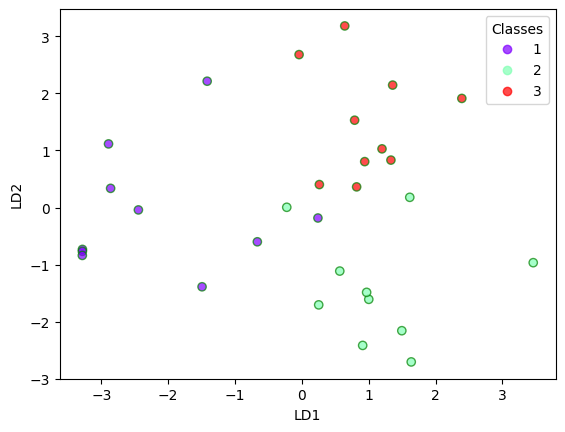

In [42]:
plt.xlabel('LD1')
plt.ylabel('LD2')
scatter = plt.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='g'
)

# Leyenda para las 10 clases
plt.legend(*scatter.legend_elements(), title="Classes")

plt.show()

### 4. Referencias  
https://towardsdatascience.com/linear-discriminant-analysis-in-python-76b8b17817c2  
https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html  
https://stackoverflow.com/questions/62610782/fishers-linear-discriminant-in-python